In [ ]:
###CNN For Detection

In [24]:
import time

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

# using scipy's 2d convolution function
conv2 = scipy.signal.convolve2d # modes include "full", "valid", and "same"

In [320]:
class CNN_Detector:

    def __init__(self):
        loaded = np.load('/tmp/lenet5_detection.npz') 
        self.x0=loaded['x0']
        self.x1=loaded['x1'] 
        self.x1p=loaded['x1p']
        self.x2=loaded['x2'] 
        self.x2p=loaded['x2p']
        self.x3=loaded['x3']
        self.x3p=loaded['x3p']
        self.epsinit=loaded['epsinit']
        self.eta=loaded['eta'] 
        self.n0=loaded['n0']
        self.n1=loaded['n1']
        self.n2=loaded['n2'] 
        self.n3=loaded['n3'] 
        self.w1=loaded['w1'] 
        self.w2=loaded['w2'] 
        self.w3=loaded['w3']
        self.b1=loaded['b1']
        self.b1p=loaded['b1p']
        self.b2=loaded['b2']
        self.b2p=loaded['b2p'] 
        self.b3=loaded['b3'] 
        self.b3p=loaded['b3p'] 
        self.n4=loaded['n4']
        self.n5=loaded['n5'] 
        self.n6=loaded['n6'] 
        self.n7=loaded['n7'] 
        self.W4=loaded['W4']
        self.W5=loaded['W5']
        self.W6=loaded['W6']
        self.W7=loaded['W7']
        self.b4=loaded['b4'] 
        self.b5=loaded['b5'] 
        self.b6=loaded['b6']
        self.b7=loaded['b7']

    def f(self, x): # hyperbolic tangent activation function
        return np.tanh(x)
    
    def df(self, y): # derivative of f composed with inverse of f
        return 1 - np.multiply(y, y)

    def maxpool(self, images):
        # 2x2 max pooling for set of images
        # returns MAXIMA, WINNERS
        # MAXIMA 2x smaller image, maximum of each 2x2 patch
        # WINNERS 2x smaller image, argmax (1..4) of each 2x2 patch

        [k, m, n] = images.shape  # mxn images, k of them
        # reshape to k x 2 x m/2 x 2 x n/2
        #print(m/2)
        #print(n/2)
        im_re = np.reshape(images, (k, int(m/2), 2, int(n/2), 2))
        maxima = np.amax(np.amax(im_re, 4), 2)

        # obtain "flat" indices for each element
        inds = np.reshape(np.array(range(im_re.size)), im_re.shape)

        # run two-step argmax to determine winning indices
        curr_inds = np.argmax(im_re, 4)
        dim0, dim1, dim2, dim3 = np.indices(curr_inds.shape)
        inds = inds[dim0, dim1, dim2, dim3, curr_inds]
        im_re = np.amax(im_re, 4)
        curr_inds = np.argmax(im_re, 2)
        dim0, dim1, dim3 = np.indices(curr_inds.shape)
        winners = inds[dim0, dim1, curr_inds, dim3]
        return maxima, winners

    def convert(self, sample):
        return np.array([sample[:,:,0],sample[:,:,1],sample[:,:,2]])
    
    def softmax(self, probs):
        result = probs.copy()
        summand = sum([np.exp(x) for x in probs])
        for i in range(len(probs)):
            result[i] = np.exp(probs[i]) / summand
        return result
    
    def forward_pass(self, sample):
        self.x0 = self.convert(sample)
        #self.x0 = sample

        self.x1 = np.zeros(self.x1.shape)   # valid convolution by w1 reduces image size by 2
        self.x1p = np.zeros(self.x1p.shape)  # pooling reduces image size by 2x
        self.x2 = np.zeros(self.x2.shape)   # convolution by w2 reduces image size by 3
        self.x2p = np.zeros(self.x2p.shape)    # pooling reduces image size by 2x
        self.x3 = np.zeros(self.x3.shape)     # convolution by w3 reduces image size by 2
        self.x3p = np.zeros(self.x3p.shape)    # pooling reduces image size by 2x

        for i in range(self.n1):
            for j in range(self.n0):
                self.x1[i,:,:] += conv2(self.x0[j,:,:], self.w1[i,j,:,:], "valid")

        for i in range(self.n1):
            self.x1[i,:,:] = self.x1[i,:,:] + self.b1[i]

        self.x1 = self.f(self.x1)
        #print(x1.shape)

        #x1p, x1w = maxpool(x1)

        for i in range(self.n1):
            self.x1p[i,:,:] = self.x1p[i,:,:] + self.b1p[i]

        self.x1p, x1w = self.maxpool(self.x1)

        for i in range(self.n2):
            for j in range(self.n1):
                self.x2[i,:,:] += conv2(self.x1p[j,:,:], self.w2[i,j,:,:], "valid")

        for i in range(self.n2):
            self.x2[i,:,:] = self.x2[i,:,:] + self.b2[i]

        self.x2 = self.f(self.x2)

        #x2p, x2w = maxpool(x2)

        for i in range(self.n2):
            self.x2p[i,:,:] = self.x2p[i,:,:] + self.b2p[i]

        self.x2p, x2w = self.maxpool(self.x2)

        for i in range(self.n3):
            for j in range(self.n2):
                self.x3[i,:,:] += conv2(self.x2p[j,:,:], self.w3[i,j,:,:], "valid")

        for i in range(self.n3):
            self.x3[i,:,:] = self.x3[i,:,:] + self.b3[i]

        self.x3 = self.f(self.x3)

        self.x3p, x3w = self.maxpool(self.x3)

        for i in range(self.n3):
            self.x3p[i,:,:] = self.x3p[i,:,:] + self.b3p[i]

        # discard 2D organization of x3p by reshaping to x3p(:)
        self.x4 = self.f(np.dot(self.W4,np.reshape(self.x3p,-1)) + self.b4)
        self.x5 = self.f(np.dot(self.W5,self.x4) + self.b5)
        self.x6 = self.f(np.dot(self.W6,self.x5) + self.b6)
        self.x7 = self.f(np.dot(self.W7,self.x6) + self.b7)
        #prediction = np.argmax(self.x7)

        #return prediction
        return self.softmax(self.x7)
     

In [26]:
topten = [2, 1, 13, 12, 38, 10, 4, 5, 25, 9]
index_map = {}
for i, sign in enumerate(topten):
    index_map[sign] = i

In [27]:
class CNN_Recognizer:

    def __init__(self):
        loaded = np.load('/tmp/lenet5.npz') 
        self.x0=loaded['x0']
        self.x1=loaded['x1'] 
        self.x1p=loaded['x1p']
        self.x2=loaded['x2'] 
        self.x2p=loaded['x2p']
        self.x3=loaded['x3']
        self.x3p=loaded['x3p']
        
        self.epsinit=loaded['epsinit']
        self.eta=loaded['eta'] 
        self.n0=loaded['n0']
        self.n1=loaded['n1']
        self.n2=loaded['n2'] 
        self.n3=loaded['n3'] 
        self.w1=loaded['w1'] 
        self.w2=loaded['w2'] 
        self.w3=loaded['w3']
        
        self.b1=loaded['b1']
        self.b1p=loaded['b1p']
        self.b2=loaded['b2']
        self.b2p=loaded['b2p'] 
        self.b3=loaded['b3'] 
        self.b3p=loaded['b3p'] 
        
        self.n4=loaded['n4']
        self.n5=loaded['n5'] 
        self.n6=loaded['n6'] 
        
        self.W4=loaded['W4']
        self.W5=loaded['W5']
        self.W6=loaded['W6']
        
        self.b4=loaded['b4'] 
        self.b5=loaded['b5'] 
        self.b6=loaded['b6']

    def f(self, x): # hyperbolic tangent activation function
        return np.tanh(x)
    
    def df(self, y): # derivative of f composed with inverse of f
        return 1 - np.multiply(y, y)

    def maxpool(self, images):
        # 2x2 max pooling for set of images
        # returns MAXIMA, WINNERS
        # MAXIMA 2x smaller image, maximum of each 2x2 patch
        # WINNERS 2x smaller image, argmax (1..4) of each 2x2 patch

        [k, m, n] = images.shape  # mxn images, k of them
        # reshape to k x 2 x m/2 x 2 x n/2
        #print(m/2)
        #print(n/2)
        im_re = np.reshape(images, (k, m/2, 2, n/2, 2))
        maxima = np.amax(np.amax(im_re, 4), 2)

        # obtain "flat" indices for each element
        inds = np.reshape(np.array(range(im_re.size)), im_re.shape)

        # run two-step argmax to determine winning indices
        curr_inds = np.argmax(im_re, 4)
        dim0, dim1, dim2, dim3 = np.indices(curr_inds.shape)
        inds = inds[dim0, dim1, dim2, dim3, curr_inds]
        im_re = np.amax(im_re, 4)
        curr_inds = np.argmax(im_re, 2)
        dim0, dim1, dim3 = np.indices(curr_inds.shape)
        winners = inds[dim0, dim1, curr_inds, dim3]
        return maxima, winners

    def convert(self, sample):
        return np.array([sample[:,:,0],sample[:,:,1],sample[:,:,2]])
    
    def forward_pass(self, sample):
        self.x0 = self.convert(sample)

        self.x1 = np.zeros(self.x1.shape)   # valid convolution by w1 reduces image size by 2
        self.x1p = np.zeros(self.x1p.shape)  # pooling reduces image size by 2x
        self.x2 = np.zeros(self.x2.shape)   # convolution by w2 reduces image size by 3
        self.x2p = np.zeros(self.x2p.shape)    # pooling reduces image size by 2x
        self.x3 = np.zeros(self.x3.shape)     # convolution by w3 reduces image size by 2
        self.x3p = np.zeros(self.x3p.shape)    # pooling reduces image size by 2x

        for i in range(self.n1):
            for j in range(self.n0):
                self.x1[i,:,:] += conv2(self.x0[j,:,:], self.w1[i,j,:,:], "valid")

        for i in range(self.n1):
            self.x1[i,:,:] = self.x1[i,:,:] + self.b1[i]

        self.x1 = self.f(self.x1)
        #print(x1.shape)

        #x1p, x1w = maxpool(x1)

        for i in range(self.n1):
            self.x1p[i,:,:] = self.x1p[i,:,:] + self.b1p[i]

        self.x1p, x1w = self.maxpool(self.x1)

        for i in range(self.n2):
            for j in range(self.n1):
                self.x2[i,:,:] += conv2(self.x1p[j,:,:], self.w2[i,j,:,:], "valid")

        for i in range(self.n2):
            self.x2[i,:,:] = self.x2[i,:,:] + self.b2[i]

        self.x2 = self.f(self.x2)

        #x2p, x2w = maxpool(x2)

        for i in range(self.n2):
            self.x2p[i,:,:] = self.x2p[i,:,:] + self.b2p[i]

        self.x2p, x2w = self.maxpool(self.x2)

        for i in range(self.n3):
            for j in range(self.n2):
                self.x3[i,:,:] += conv2(self.x2p[j,:,:], self.w3[i,j,:,:], "valid")

        for i in range(self.n3):
            self.x3[i,:,:] = self.x3[i,:,:] + self.b3[i]

        self.x3 = self.f(self.x3)

        self.x3p, x3w = self.maxpool(self.x3)

        for i in range(self.n3):
            self.x3p[i,:,:] = self.x3p[i,:,:] + self.b3p[i]

        # discard 2D organization of x3p by reshaping to x3p(:)
        self.x4 = self.f(np.dot(self.W4,np.reshape(self.x3p,-1)) + self.b4)
        self.x5 = self.f(np.dot(self.W5,self.x4) + self.b5)
        self.x6 = self.f(np.dot(self.W6,self.x5) + self.b6)
        prediction = np.argmax(self.x6)

        return topten[prediction]
     

In [28]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import os 

from sklearn.feature_extraction.text import CountVectorizer
import nltk, re
from nltk.corpus import stopwords
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model 

import pickle
from sklearn.externals import joblib

In [29]:
def correctShape(data):
    num_samples = len(data)
    len_samples = len(data[0])
    new_data = []
    count = 0

    for i in range(num_samples):
        new_data.append([data[i][j][0] for j in range(len_samples)])    

        if count % 5000 == 0:
            print(count)
        count += 1 
        
    return new_data

In [293]:
##Run SVM Classifier for Dectection on HoG
loaded = np.load('/tmp/ml_detection.npz')
total_hog_train=loaded['total_hog_train'] 
total_hog_train_labels=loaded['total_hog_train_labels']    
total_hog_test=loaded['total_hog_test']
total_hog_test_labels=loaded['total_hog_test_labels']

In [294]:
total_hog_train = correctShape(total_hog_train)
total_hog_test = correctShape(total_hog_test)
print(len(total_hog_train))
print(len(total_hog_test))

0
5000
10000
15000
20000
0
5000
25000
8000


In [295]:
from sklearn.decomposition import PCA
#pca_detection = PCA(n_components=1000, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
pca_trainVectors_hog = pca_detection.fit_transform(total_hog_train)
pca_testVectors_hog = pca_detection.transform(total_hog_test)
testLabels_hog = total_hog_test_labels
trainLabels_hog = total_hog_train_labels
print(len(pca_trainVectors_hog[0]))
print(len(pca_testVectors_hog[0]))

1000
1000


In [33]:
start_time = time.time()
linear_svc_hog = svm.LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', 
                    fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=1, random_state=None, 
                    max_iter=1000)
linear_svc_hog.fit(pca_trainVectors_hog, trainLabels_hog)
linear_svc_hog_prediction = linear_svc_hog.predict(pca_testVectors_hog)
print("Accuracy: " + str(metrics.accuracy_score(linear_svc_hog_prediction, testLabels_hog)))
print("F1: " + str(metrics.f1_score(linear_svc_hog_prediction, testLabels_hog, average=None)))
print("--- %s seconds ---" % (time.time() - start_time))

[LibLinear]Accuracy: 0.988875
F1: [0.98832787 0.98937313]


In [301]:
#svm_detector_linear = svm_detector
svm_detector_linear = linear_svc_hog

In [300]:
start_time = time.time()
svc_hog = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=True, 
                  tol=0.001, cache_size=200, class_weight=None, verbose=True, max_iter=-1, decision_function_shape='ovr', 
                  random_state=None)
svc_hog.fit(pca_trainVectors_hog, trainLabels_hog)
print("--- %s seconds ---" % (time.time() - start_time))

--- 618.7068388462067 seconds ---


In [299]:
svc_hog_prediction = svc_hog.predict(pca_testVectors_hog)
print("Accuracy: " + str(metrics.accuracy_score(svc_hog_prediction, testLabels_hog)))
print("F1: " + str(metrics.f1_score(svc_hog_prediction, testLabels_hog, average=None)))

Accuracy: 0.9865
F1: [0.98590078 0.98705036]


In [302]:
svm_detector_radial = svc_hog

In [35]:
# loaded = np.load('/tmp/distribution_data.npz')
loaded = np.load('/tmp/ml_classification.npz')
hog_pos_train=loaded['hog_pos_train']
hog_pos_train_label=loaded['hog_pos_train_label']
hog_pos_test=loaded['hog_pos_test'] 
hog_pos_test_label=loaded['hog_pos_test_label']

In [36]:
hog_pos_train = correctShape(hog_pos_train)
hog_pos_test = correctShape(hog_pos_test)

0
5000
10000
0


In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1000, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
pca_trainVectors_hog = pca.fit_transform(hog_pos_train)
pca_testVectors_hog = pca.transform(hog_pos_test)
testLabels_hog = hog_pos_test_label
trainLabels_hog = hog_pos_train_label
print(len(pca_trainVectors_hog[0]))
print(len(pca_testVectors_hog[0]))

1000
1000


In [38]:
linear_svc_hog = svm.LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', 
                    fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=1, random_state=None, 
                    max_iter=1000)
linear_svc_hog.fit(pca_trainVectors_hog, trainLabels_hog)
linear_svc_hog_prediction = linear_svc_hog.predict(pca_testVectors_hog)
print("Accuracy: " + str(metrics.accuracy_score(linear_svc_hog_prediction, testLabels_hog)))
print("F1: " + str(metrics.f1_score(linear_svc_hog_prediction, testLabels_hog, average=None)))

[LibLinear]Accuracy: 0.9566859733064719
F1: [0.89432703 0.90872211 0.9750983  0.83881064 0.9739479  0.98385093
 0.998      0.99696663 1.         0.99373695]


In [39]:
svm_recognizer = linear_svc_hog

In [40]:
cnn_recognizer = CNN_Recognizer()

In [38]:
loaded = np.load('/tmp/classification.npz')
positives = loaded['positives']
pos_label = loaded['pos_label']

#shuffle data
positives = np.array(positives)
pos_label = np.array(pos_label)
indexes = [i for i in range(0,len(positives))]
np.random.shuffle(indexes)
positives = positives[indexes]
pos_label = pos_label[indexes]

In [41]:
start_time = time.time()
predictions = []
for sample in positives[:500]:
    predictions.append(cnn_recognizer.forward_pass(sample))
print("--- %s seconds ---" % (time.time() - start_time))

--- 16.0099561214 seconds ---


In [42]:
count = 0
for i, prediction in enumerate(predictions):
    if prediction != pos_label[i]:
        count += 1

print("Total Classification Error: " + str(float(count) / float(len(predictions))))

Total Classification Error: 0.026


In [321]:
cnn_detector = CNN_Detector()

In [26]:
loaded = np.load('/tmp/dl_detection.npz')
total=loaded['total']
labels=loaded['labels']
print(total.shape)
print(labels.shape)

test = total[25000:25500]
testlabels = labels[25000:25500]

(35765, 3, 40, 40)
(35765,)


In [27]:
start_time = time.time()
predictions = []
for sample in test:
    predictions.append(cnn_detector.forward_pass(sample))
print("--- %s seconds ---" % (time.time() - start_time))

--- 15.7357470989 seconds ---


In [28]:
count = 0
for i, prediction in enumerate(predictions):
    if prediction != testlabels[i]:
        count += 1

print("Total Classification Error: " + str(float(count) / float(len(predictions))))

Total Classification Error: 0.066


In [8]:
def getDataGTSDB(rootpath):
    data = []
    gtFile = open(rootpath)
    gtReader = csv.reader(gtFile, delimiter=';')
    data = []
    for row in gtReader:
        data.append(row)
    gtFile.close()        
    return data

data = getDataGTSDB('./FullIJCNN2013/gt.txt')
matches = []
for row in data:
    if int(row[5]) in topten:
        if matches[-1:] != row[0]:
            matches.append(row[0])
            
print(len(matches))

689


In [9]:
#Read in Detection Images, Only Those with TopTen Instances

images = []
for i,match in enumerate(matches):
    images.append(plt.imread('./FullIJCNN2013/' + match)) 
    if i % 50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450
500
550
600
650


In [ ]:
#Bounding Box Generation

In [263]:
dimensions = [25,30,35,40,50,60,80]

test = images[0]
height = len(test)
width = len(test[0])

bboxes = []
coords = []
start_time = time.time()
for dim in dimensions:
    for i in np.arange(0,height-dim,dim):
        for j in np.arange(0,width-dim,dim):
            bboxes.append(test[i:(i+dim),j:(j+dim),:])
            coords.append((i,j))
print("--- %s seconds ---" % (time.time() - start_time))
print(len(bboxes))

--- 0.010944128036499023 seconds ---
5142


In [332]:
print(coords[0:10])

[(0, 0), (0, 25), (0, 50), (0, 75), (0, 100), (0, 125), (0, 150), (0, 175), (0, 200), (0, 225)]


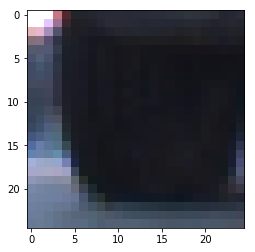

In [250]:
n = np.random.randint(len(bboxes))
plt.imshow(bboxes[n])

In [224]:
for bbox in bboxes:
    if len(bbox) not in dimensions or len(bbox[0]) != len(bbox):
        print("wow")
        

In [225]:
print(width)
print(height)

1360
800


In [257]:
image_copy = test.copy()

count = 0
dimensions = [25]
for dim in dimensions:
    for i in np.arange(0,height-dim,dim):
        for j in np.arange(0,width-dim,dim):
            count += 1
            cv2.rectangle(image_copy,(j,i),(j+dim,i+dim),(255,255,255),2)
print(count)

1674


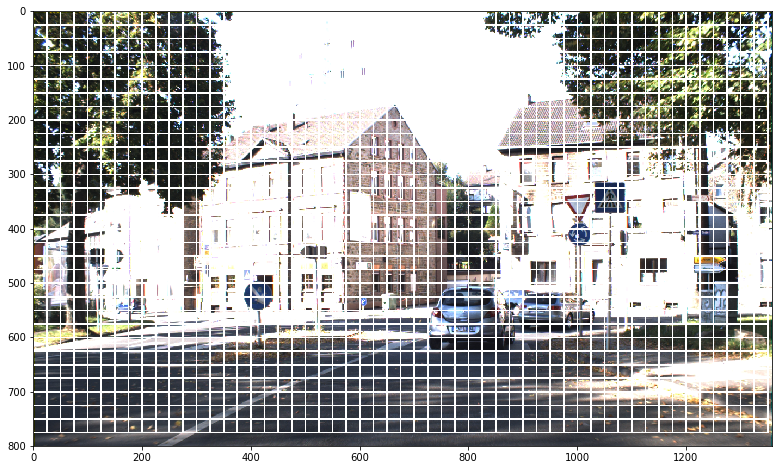

In [258]:
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 8), sharex=True, sharey=True)
     
ax1.imshow(image_copy)    

In [259]:
image_copy = test.copy()

count = 0
dimensions = [30]
for dim in dimensions:
    for i in np.arange(0,height-dim,dim):
        for j in np.arange(0,width-dim,dim):
            count += 1
            cv2.rectangle(image_copy,(j,i),(j+dim,i+dim),(255,255,255),2)
print(count)

1170


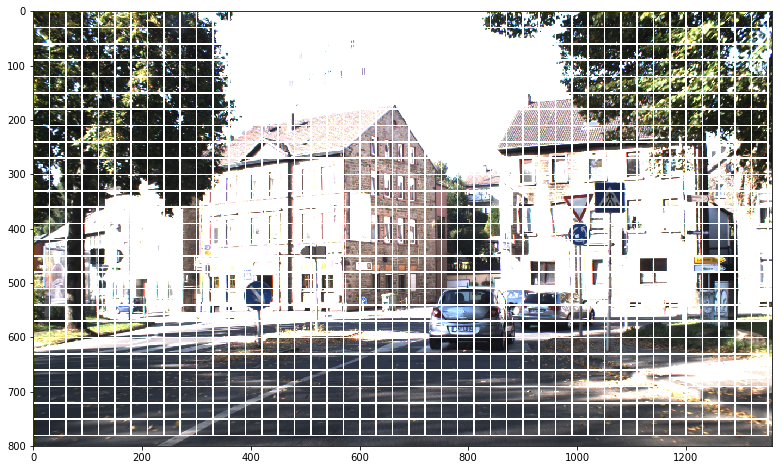

In [260]:
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 8), sharex=True, sharey=True)
     
ax1.imshow(image_copy)    

In [261]:
image_copy = test.copy()

count = 0
dimensions = [80]
for dim in dimensions:
    for i in np.arange(0,height-dim,dim):
        for j in np.arange(0,width-dim,dim):
            count += 1
            cv2.rectangle(image_copy,(j,i),(j+dim,i+dim),(255,255,255),2)
print(count)

144


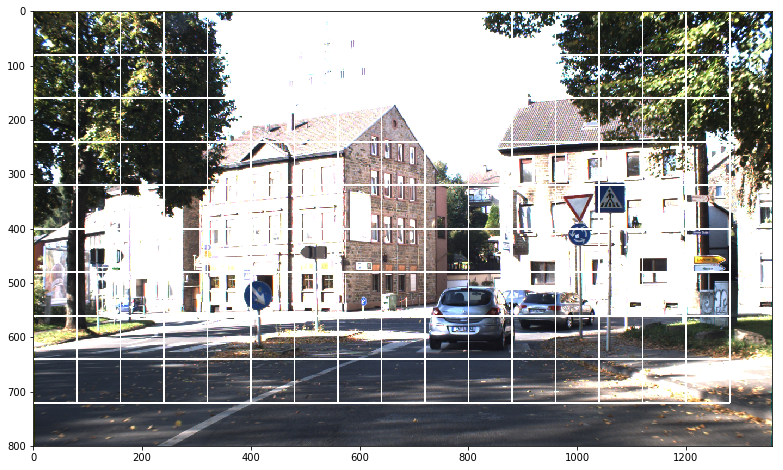

In [262]:
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 8), sharex=True, sharey=True)
     
ax1.imshow(image_copy)    

In [43]:
import cv2

winSize = (40,40)
blockSize = (10,10)
blockStride = (5,5)
cellSize = (5,5)
nbins = 8
derivAperture = 1
winSigma = 4. #Gaussian smoothing window parameter
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 32
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

In [335]:
#Run svm detector

start_time = time.time()

svm_detector_data = []
for i in range(len(bboxes)):
    svm_detector_data.append(hog.compute(cv2.resize(bboxes[i], (40, 40))))

svm_detector_data = correctShape(svm_detector_data)
        
svm_detector_data = pca_detection.transform(svm_detector_data)

predictions = svm_detector_radial.predict(svm_detector_data)
probabilites = svm_detector_radial.predict_proba(svm_detector_data)

print("--- %s seconds ---" % (time.time() - start_time))
#print('svm_detetector_linear')
#print("--- %s seconds ---" % (5.601348876953125))

0
5000
--- 43.108376026153564 seconds ---


In [336]:
print(predictions[0:10])
print(probabilites[0:10])

[1 0 0 0 0 0 0 0 0 0]
[[1.61276636e-02 9.83872336e-01]
 [9.95527708e-01 4.47229214e-03]
 [9.24929119e-01 7.50708812e-02]
 [9.86167558e-01 1.38324417e-02]
 [9.94019397e-01 5.98060276e-03]
 [9.99309465e-01 6.90535071e-04]
 [9.99995925e-01 4.07497170e-06]
 [9.99780150e-01 2.19850468e-04]
 [9.71155900e-01 2.88440996e-02]
 [9.73196750e-01 2.68032498e-02]]


In [337]:
winners = [bboxes[i] for i, x in enumerate(predictions) if x == 1]
winners_coord = [coords[i] for i, x in enumerate(predictions) if x == 1]
print(len(winners))

57


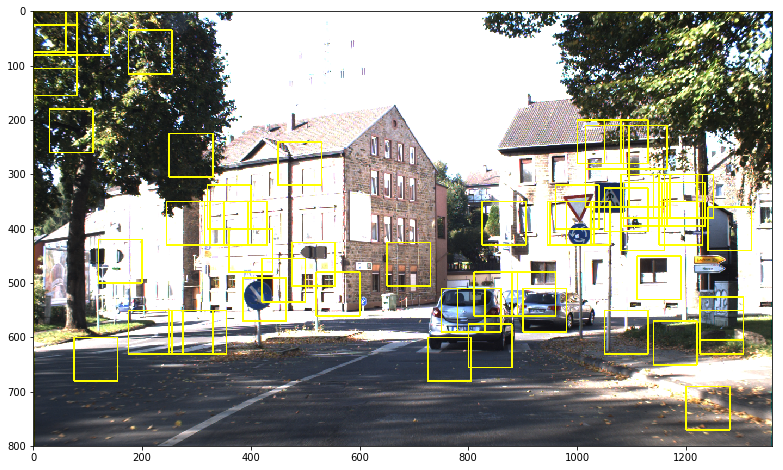

In [338]:
image_copy = test.copy()

for coord in winners_coord:
    i = coord[0]
    j = coord[1]
    cv2.rectangle(image_copy,(j,i),(j+dim,i+dim),(255,255,0),2)

fig, (ax1) = plt.subplots(1, 1, figsize=(20, 8), sharex=True, sharey=True)
     
ax1.imshow(image_copy)    

In [339]:
#Display only highest probability boxes first
bboxes_sorted = bboxes.copy()
coords_sorted = coords.copy()
prob_sign = np.array([sample[1] for sample in probabilites])
indexes = np.argsort(prob_sign)[::-1] #descending order
prob_sign = prob_sign[indexes]
predictions = np.array(predictions)
predictions = predictions[indexes]
bboxes_sorted = np.array(bboxes_sorted)
bboxes_sorted = bboxes_sorted[indexes]
coords_sorted = np.array(coords_sorted)
coords_sorted = coords_sorted[indexes]

print(prob_sign[0:10])
print(prob_sign[-10:])

[0.99999997 0.99999996 0.99999705 0.9957341  0.99558096 0.99282156
 0.98387234 0.98377261 0.97724667 0.97151335]
[1.0000001e-07 1.0000001e-07 1.0000001e-07 1.0000001e-07 1.0000001e-07
 1.0000001e-07 1.0000001e-07 1.0000001e-07 1.0000001e-07 1.0000001e-07]


In [340]:
winners = [bboxes_sorted[i] for i, x in enumerate(predictions) if x == 1]
winners_coord = [coords_sorted[i] for i, x in enumerate(predictions) if x == 1]
print(len(winners))

57


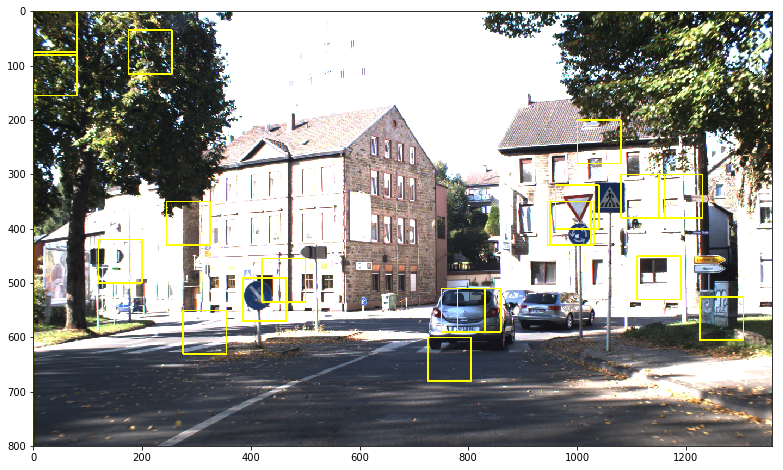

In [344]:
image_copy = test.copy()

for coord in winners_coord[:20]:
    i = coord[0]
    j = coord[1]
    cv2.rectangle(image_copy,(j,i),(j+dim,i+dim),(255,255,0),2)

fig, (ax1) = plt.subplots(1, 1, figsize=(20, 8), sharex=True, sharey=True)
     
ax1.imshow(image_copy)    

In [265]:
len(coords)

5142

In [291]:
#Run cnn detector

cnn_detector_data = []
for i in range(len(bboxes)):
    cnn_detector_data.append(cv2.resize(bboxes[i], (40, 40)))

for i in range(len(bboxes)):
    cnn_detector_data[i] = cnn_detector_data[i] / np.mean(cnn_detector_data[i])

start_time = time.time()
predictions = []
for sample in cnn_detector_data:
    predictions.append(cnn_detector.forward_pass(sample))
print("--- %s seconds ---" % (time.time() - start_time))

cnn_detection_winners = [bboxes[i] for i, x in enumerate(predictions) if x == 1]
cnn_detection_coords = [coords[i] for i, x in enumerate(predictions) if x == 1]
print(len(cnn_detection_winners))

--- 83.20991921424866 seconds ---
65


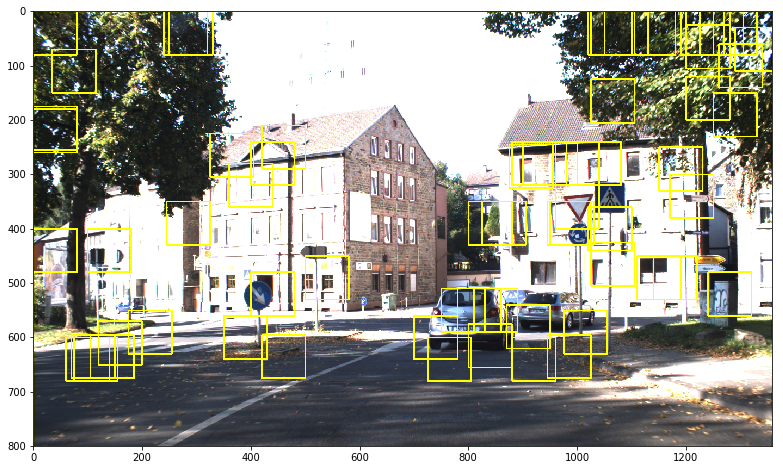

In [292]:
image_copy = test.copy()

for coord in cnn_detection_coords:
    i = coord[0]
    j = coord[1]
    cv2.rectangle(image_copy,(j,i),(j+dim,i+dim),(255,255,0),2)

fig, (ax1) = plt.subplots(1, 1, figsize=(20, 8), sharex=True, sharey=True)
     
ax1.imshow(image_copy)    

In [322]:
#Run cnn detector with probabilies

start_time = time.time()
probabilities = []
for sample in cnn_detector_data:
    probabilities.append(cnn_detector.forward_pass(sample))
print("--- %s seconds ---" % (time.time() - start_time))

print(probabilities[0:10])

--- 99.12702012062073 seconds ---
[array([0.13045951, 0.86954049]), array([0.83492719, 0.16507281]), array([0.74514931, 0.25485069]), array([0.81019723, 0.18980277]), array([0.87207523, 0.12792477]), array([0.87311966, 0.12688034]), array([0.87155972, 0.12844028]), array([0.8724638, 0.1275362]), array([0.6813272, 0.3186728]), array([0.79603348, 0.20396652])]
[1 1 1 1 1 1 1 1 1 1]


In [323]:
predictions = []
for i in range(len(probabilities)):
    if probabilities[i][1] > probabilities[i][0]:
        predictions.append(1)
    else:
        predictions.append(0)
print(predictions[0:10])

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [324]:
#Display only highest probability boxes first
bboxes_sorted = bboxes.copy()
coords_sorted = coords.copy()
prob_sign = np.array([sample[1] for sample in probabilities])
indexes = np.argsort(prob_sign)[::-1] #descending order
prob_sign = prob_sign[indexes]
predictions = np.array(predictions)
predictions = predictions[indexes]
bboxes_sorted = np.array(bboxes_sorted)
bboxes_sorted = bboxes_sorted[indexes]
coords_sorted = np.array(coords_sorted)
coords_sorted = coords_sorted[indexes]

In [325]:
winners = [bboxes_sorted[i] for i, x in enumerate(predictions) if x == 1]
winners_coord = [coords_sorted[i] for i, x in enumerate(predictions) if x == 1]
print(len(winners))

65


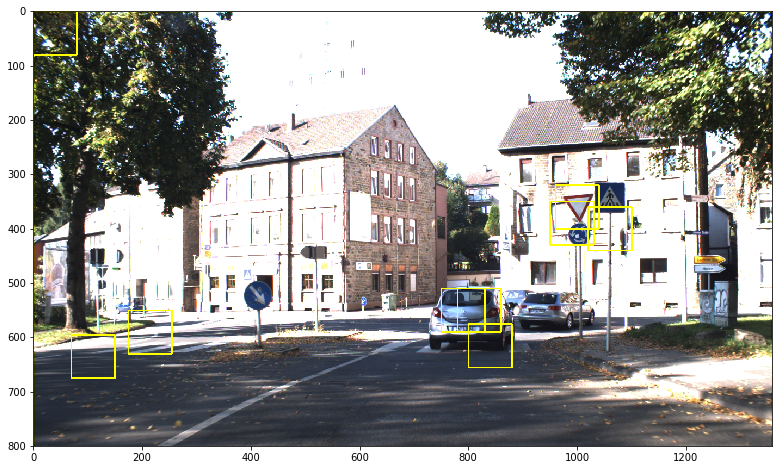

In [329]:
image_copy = test.copy()

for coord in winners_coord[:10]:
    i = coord[0]
    j = coord[1]
    cv2.rectangle(image_copy,(j,i),(j+dim,i+dim),(255,255,0),2)

fig, (ax1) = plt.subplots(1, 1, figsize=(20, 8), sharex=True, sharey=True)
     
ax1.imshow(image_copy)    